<a href="https://colab.research.google.com/github/shidan619/FYP/blob/main/Module%202.6%20-%20daraz_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers
! pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import torch

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Found GPU at: /device:GPU:0


'Tesla T4'

In [4]:
import nltk
import pandas as pd
import spacy
from nltk.tokenize import sent_tokenize
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer, AutoModelForSequenceClassification, BertForSequenceClassification, BertTokenizer

nltk.download("punkt")

def add_full_stop(text):
    last_character = text[-1]
    if last_character != ".":
        text += "."
    return text

# Read the CSV file and extract the comments column
data = pd.read_csv("/content/drive/MyDrive/zidan/daraz_predictions.csv")

comments = data["Review"]
category = data["Category"]
product_name = data["Product Name"]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
# Initialize tokenizer and model for T5 text generation
tokenizer = T5Tokenizer.from_pretrained("flax-community/t5-base-wikisplit")
model = T5ForConditionalGeneration.from_pretrained("flax-community/t5-base-wikisplit")

# Initialize tokenizer and model for aspect sentiment analysis
aspect_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
aspect_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# Initialize tokenizer and model for aspect classification
classification_model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/zidan/finetuned_bert', num_labels=7)
classification_tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/zidan/finetuned_bert', do_lower_case=True)

# Move models to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
aspect_model.to(device)
classification_model.to(device)

def assign_sentiment_label(sentiment_score):
    if sentiment_score >= 0.99983:
        sentiment_label = 'very good'
    elif sentiment_score >= 0.999:
        sentiment_label = 'good'
    elif sentiment_score > 0.001:
        sentiment_label = 'neutral'
    elif sentiment_score > 0.0002:
        sentiment_label = 'bad'
    else:
        sentiment_label = 'poor'
    return sentiment_label


# Define aspect labels
aspect_labels = ["price", "quality", "delivery", "packaging", "design", "customer service", "usability"]

# Initialize spaCy for sentence tokenization
nlp = spacy.load("en_core_web_sm")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
# Initialize the results list to store the processed data
results = []

# Process each comment and its sentences
for comment in comments:
    sentences = sent_tokenize(comment)

    for sentence in sentences:
        # Add full stop if necessary
        input_sentence = add_full_stop(sentence)

        # Tokenize and generate simple sentences using T5 model
        encoder_max_length = 256
        decoder_max_length = 256
        complex_tokenized = tokenizer(input_sentence, padding="max_length", truncation=True, max_length=encoder_max_length, return_tensors='pt').to(device)
        simple_tokenized = model.generate(complex_tokenized['input_ids'].to(device), attention_mask=complex_tokenized['attention_mask'].to(device), max_length=decoder_max_length, num_beams=1)
        simple_sentences = tokenizer.batch_decode(simple_tokenized, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        # Perform aspect classification
        input_statements = [statement.strip() for statement in simple_sentences if statement.strip()]

        encoded_inputs = classification_tokenizer.batch_encode_plus(
            input_statements,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=512
        ).to(device)

        with torch.no_grad():
            classification_model.eval()
            outputs = classification_model(**encoded_inputs)
            predicted_labels = outputs.logits

        predicted_labels = (torch.sigmoid(predicted_labels) > 0.5).to(torch.int).tolist()

        # Perform aspect sentiment analysis for each aspect
        aspect_sentiment_labels = {}
        aspect_sentiment_scores = {}

        for aspect_label in aspect_labels:
            aspect_sentiment_labels[aspect_label] = []
            aspect_sentiment_scores[aspect_label] = []

        for statement_index, statement in enumerate(input_statements):
            for aspect_index, aspect_label in enumerate(aspect_labels):
                if predicted_labels[statement_index][aspect_index] == 1:
                    inputs = aspect_tokenizer.encode_plus(statement, add_special_tokens=True, return_tensors="pt").to(device)
                    input_ids = inputs["input_ids"]
                    attention_mask = inputs["attention_mask"]

                    with torch.no_grad():
                        outputs = aspect_model(input_ids.to(device), attention_mask=attention_mask.to(device))
                        logits = outputs.logits

                    probabilities = torch.softmax(logits, dim=1)
                    sentiment_score = probabilities[0][1].item()  # Positive sentiment score
                    sentiment_label = assign_sentiment_label(sentiment_score)

                    aspect_sentiment_labels[aspect_label].append(sentiment_label)
                    aspect_sentiment_scores[aspect_label].append(sentiment_score)
                else:
                    aspect_sentiment_labels[aspect_label].append("-")
                    aspect_sentiment_scores[aspect_label].append("-")

        # Calculate the average sentiment score for each aspect
        overall_sentiment_scores = []
        for aspect_label in aspect_labels:
            numeric_scores = [score for score in aspect_sentiment_scores[aspect_label] if isinstance(score, float)]
            if numeric_scores:
                aspect_sentiment_scores[aspect_label] = sum(numeric_scores) / len(numeric_scores)
            else:
                aspect_sentiment_scores[aspect_label] = "-"

        # Calculate the overall sentiment label and score for the input sentence
        numeric_scores = [score for score in aspect_sentiment_scores.values() if isinstance(score, float)]
        if numeric_scores:
            overall_sentiment_score = sum(numeric_scores) / len(numeric_scores)
            overall_sentiment_label = assign_sentiment_label(overall_sentiment_score)
        else:
            overall_sentiment_score = "-"
            overall_sentiment_label = "-"

        # Store the result in a dictionary
        result = {
            "Comment": comment,
            "Sentence": input_sentence,
            "Overall Sentiment Score": overall_sentiment_score,
            "Overall Sentiment Label": overall_sentiment_label,
        }

        # Calculate the average sentiment label for each aspect
        average_sentiment_labels = {}
        for aspect_label in aspect_labels:
            sentiment_labels = [label for label in aspect_sentiment_labels[aspect_label] if label != "-"]
            if sentiment_labels:
                average_sentiment_labels[aspect_label] = max(set(sentiment_labels), key=sentiment_labels.count)
            else:
                average_sentiment_labels[aspect_label] = "-"

            # Add aspect sentiment label to the result dictionary
            result[aspect_label] = average_sentiment_labels[aspect_label]

        # Append the result to the results list
        results.append(result)

# Create DataFrame from the results list
result_df = pd.DataFrame(results)

In [7]:
# Create an empty dictionary to store the results for each comment
comment_results = {}

# Iterate over the results
for result in results:
    comment = result['Comment']

    # Check if the comment is already in the dictionary
    if comment in comment_results:
        # Update the overall sentiment score and label
        overall_sentiment_score = comment_results[comment]['Overall Sentiment Score']
        overall_sentiment_label = comment_results[comment]['Overall Sentiment Label']
        num_results = comment_results[comment]['Num Results']

        # Convert sentiment scores to float if necessary
        overall_sentiment_score = float(overall_sentiment_score)
        new_sentiment_score = float(result['Overall Sentiment Score']) if result['Overall Sentiment Score'] != '-' else 0.0

        # Calculate the running average for the sentiment score
        overall_sentiment_score = (overall_sentiment_score * num_results + new_sentiment_score) / (num_results + 1)

        # Update the overall sentiment label if necessary
        if result['Overall Sentiment Label'] != '-':
            overall_sentiment_label = result['Overall Sentiment Label']

        # Update the comment's result with the updated values
        comment_results[comment]['Overall Sentiment Score'] = overall_sentiment_score
        comment_results[comment]['Overall Sentiment Label'] = overall_sentiment_label
        comment_results[comment]['Num Results'] += 1

        # Update the aspect sentiment labels
        for aspect_label in aspect_labels:
            if result[aspect_label] != '-':
                comment_results[comment][aspect_label].append(result[aspect_label])

    else:
        # Create a new entry for the comment in the dictionary
        comment_results[comment] = {
            'Comment': comment,
            'Overall Sentiment Score': float(result['Overall Sentiment Score']) if result['Overall Sentiment Score'] != '-' else 0.0,
            'Overall Sentiment Label': result['Overall Sentiment Label'],
            'Num Results': 1,
        }

        # Initialize the aspect sentiment labels
        for aspect_label in aspect_labels:
            if result[aspect_label] != '-':
                comment_results[comment][aspect_label] = [result[aspect_label]]
            else:
                comment_results[comment][aspect_label] = []



In [8]:
final_results = []

# Convert the comment results dictionary into a list of dictionaries
for comment_result, category, product_name in zip(comment_results.values(), category, product_name):
    # Calculate the average sentiment label for each aspect
    average_sentiment_labels = {}
    for aspect_label in aspect_labels:
        sentiment_labels = comment_result[aspect_label]
        if sentiment_labels:
            average_sentiment_labels[aspect_label] = max(set(sentiment_labels), key=sentiment_labels.count)
        else:
            average_sentiment_labels[aspect_label] = "-"

    # Create the final result dictionary for the comment
    final_result = {
        'Comment': comment_result['Comment'],
        'Overall Sentiment Score': comment_result['Overall Sentiment Score'],
        'Overall Sentiment Label': assign_sentiment_label(comment_result['Overall Sentiment Score']),
        'Category': category,  # Add the "Category" column
        'Product Name':product_name,
    }

    # Add the aspect sentiment labels to the final result dictionary
    for aspect_label in aspect_labels:
        final_result[aspect_label] = average_sentiment_labels[aspect_label]

    # Append the final result to the list
    final_results.append(final_result)

# Create DataFrame from the final results list
result_df = pd.DataFrame(final_results, columns=["Product Name","Category","Comment", "Overall Sentiment Score", "Overall Sentiment Label"] + aspect_labels)

result_df.to_csv('/content/drive/MyDrive/zidan/daraz_sentiment_analysis.csv', index=False)


In [9]:
result_df

,Product Name,Category,Comment,Overall Sentiment Score,Overall Sentiment Label,price,quality,delivery,packaging,design,customer service,usability
0,"Sunlight Care Detergent Liquid, 1L",Laundry,I purchased 2 bottles. Both seem partially use...,0.208559,neutral,neutral,bad,-,neutral,-,-,bad
1,"Sunlight Care Detergent Liquid, 1L",Laundry,Very fast & safe delivery . Neet packing. I wi...,0.505488,neutral,neutral,very good,good,neutral,-,-,-
2,"Sunlight Care Detergent Liquid, 1L",Laundry,Fast delivery during this pandemic. Got the pr...,0.747320,neutral,-,-,neutral,neutral,-,very good,-
3,"Sunlight Care Detergent Liquid, 1L",Laundry,Alot of liquid has leaked.im very much disappo...,0.000257,bad,-,-,-,bad,-,-,-
4,"Sunlight Care Detergent Liquid, 1L",Laundry,Thank you very much !! I received my package t...,0.599767,neutral,-,-,good,good,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...
1774,Puredale Full Cream Milk Powder 400g,MilkPowder,very good product value for the price,0.999854,very good,very good,-,-,-,-,-,-
1775,Puredale Full Cream Milk Powder 400g,MilkPowder,Delivery within 1day to Tangalle... well packe...,0.993837,neutral,neutral,-,neutral,neutral,-,good,-
1776,Puredale Full Cream Milk Powder 400g,MilkPowder,high quality reasonable price,0.999595,good,good,good,-,-,-,-,-
1777,Puredale Full Cream Milk Powder 400g,MilkPowder,Excellent packaging. And it was delivered quic...,0.494646,neutral,neutral,very good,neutral,very good,-,neutral,-


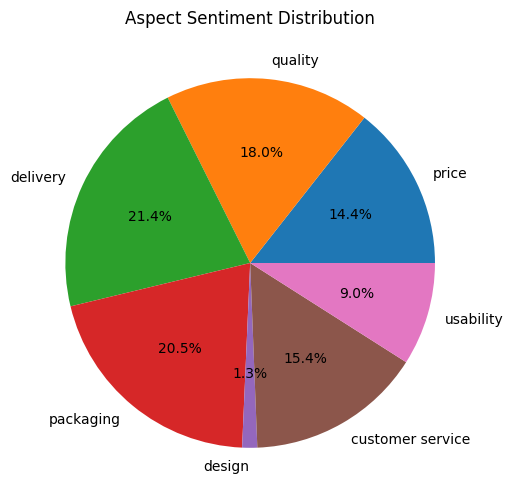

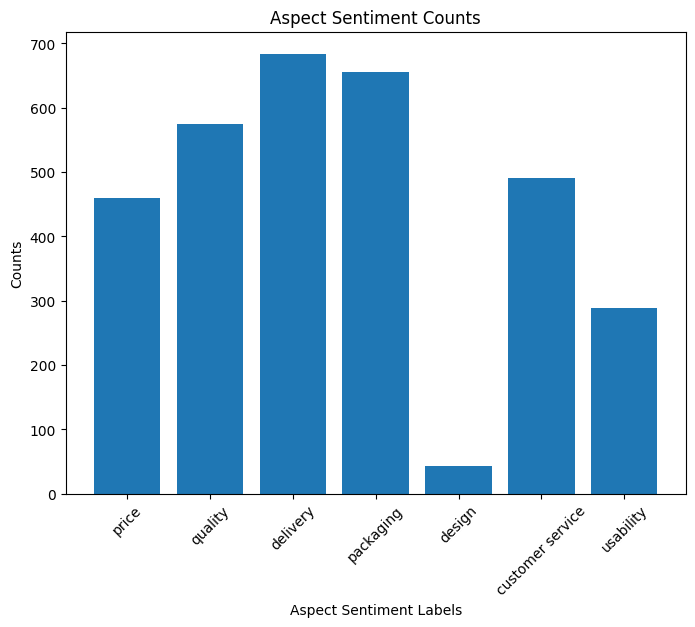

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the dataset from the CSV file
dataset = pd.read_csv('/content/drive/MyDrive/zidan/daraz_sentiment_analysis.csv')

# Get the aspect sentiment labels from the dataset
aspect_labels = [
    'price', 'quality', 'delivery', 'packaging', 'design', 'customer service', 'usability'
]

# Initialize counts as a dictionary
counts = {}

# Iterate over the aspect sentiment labels
for label in aspect_labels:
    # Count the occurrences of '1' for each label
    count = dataset[label].apply(lambda x: 1 if x == 'good' or x == 'very good' or x == 'neutral' or x == 'bad' or x == 'poor' else 0).sum()
    counts[label] = count

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(list(counts.values()), labels=list(counts.keys()), autopct='%1.1f%%')
plt.title('Aspect Sentiment Distribution')
plt.show()

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(list(counts.keys()), list(counts.values()))
plt.xlabel('Aspect Sentiment Labels')
plt.ylabel('Counts')
plt.title('Aspect Sentiment Counts')
plt.xticks(rotation=45)
plt.show()


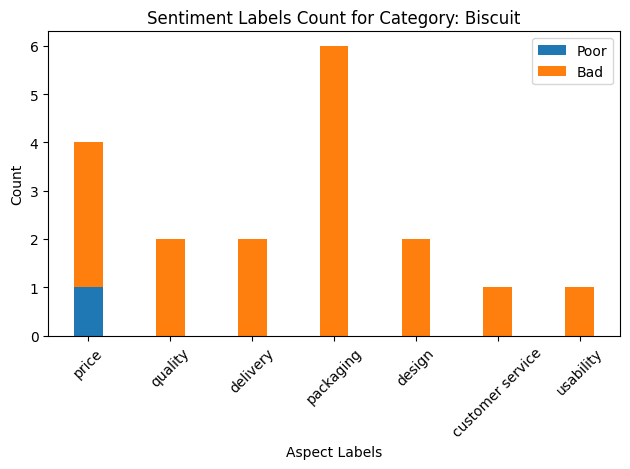

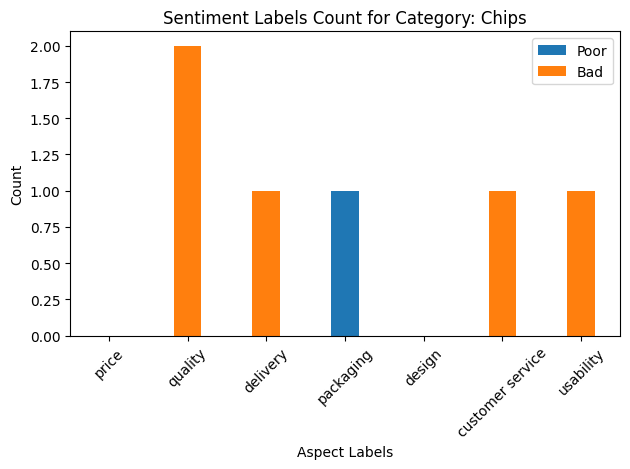

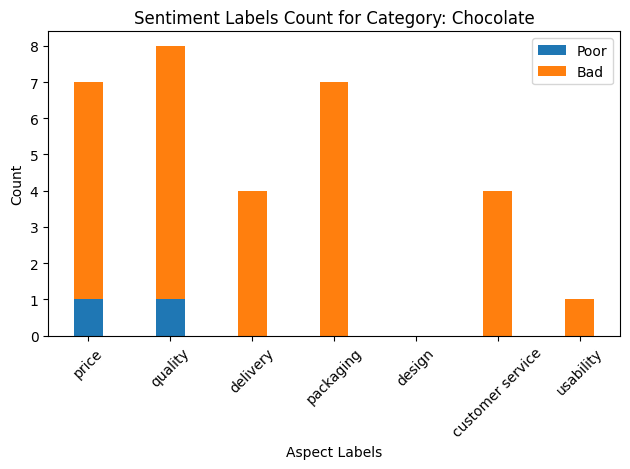

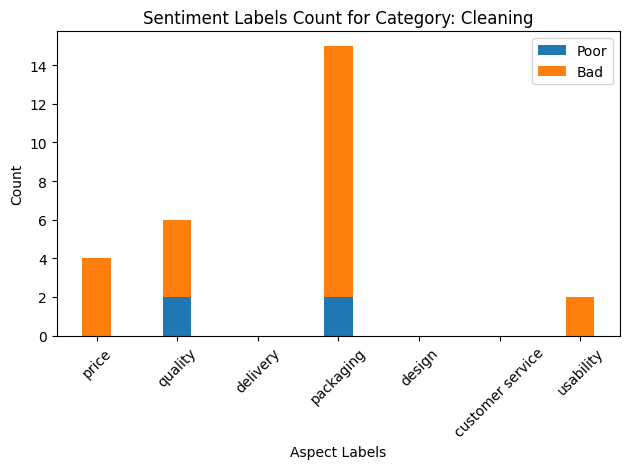

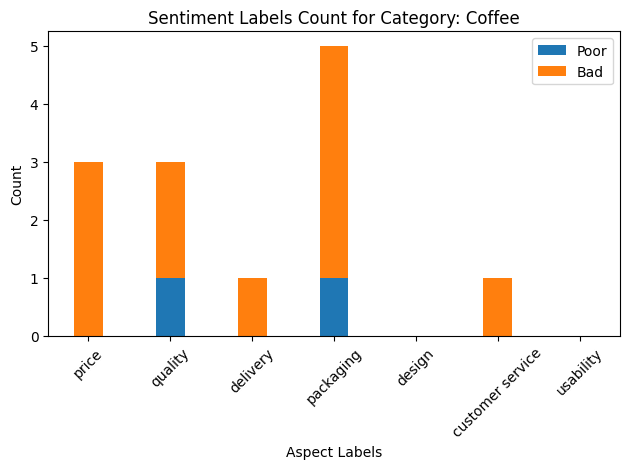

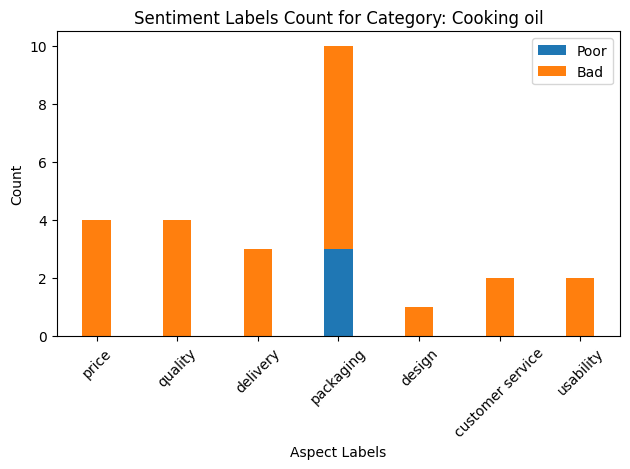

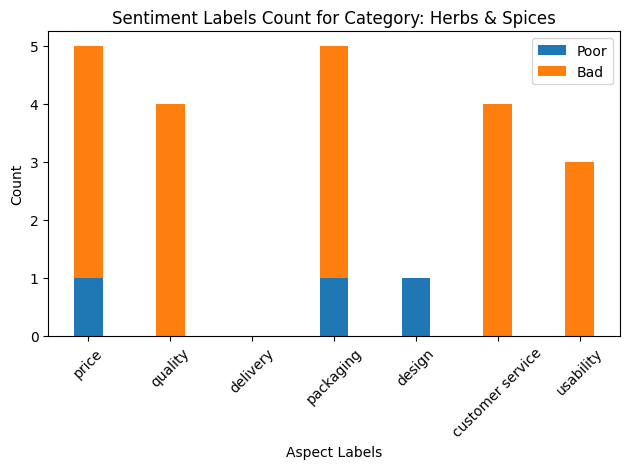

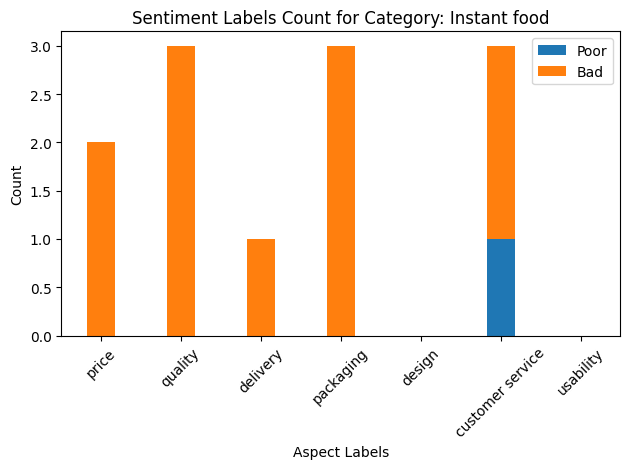

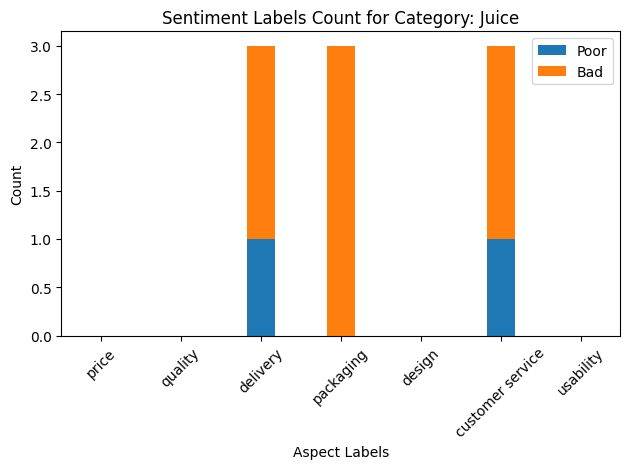

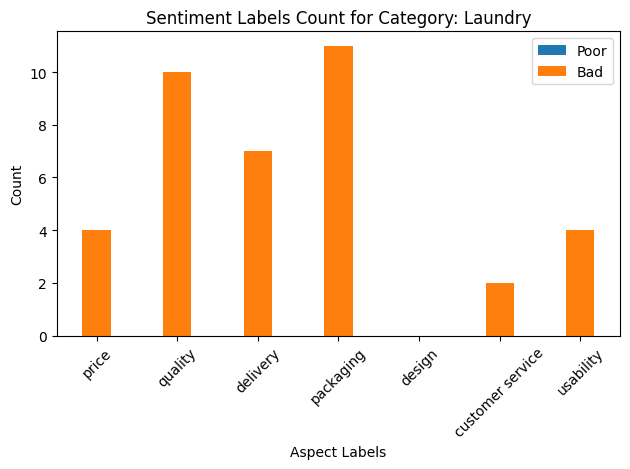

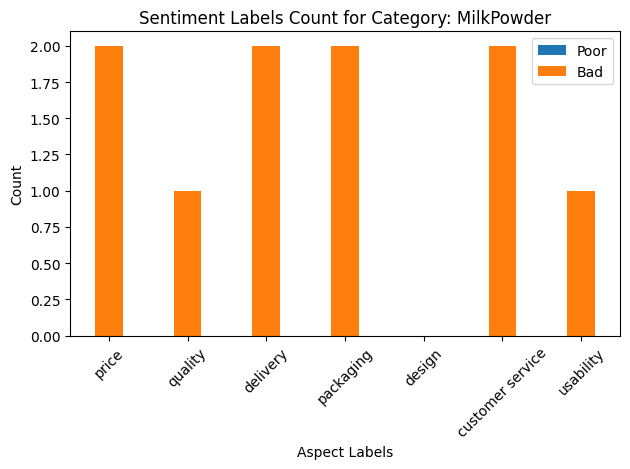

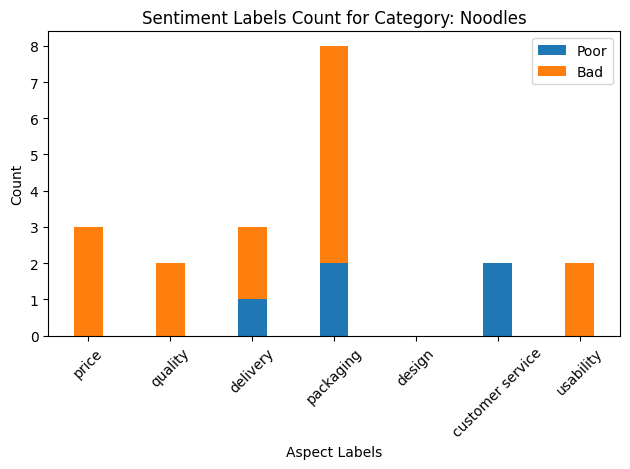

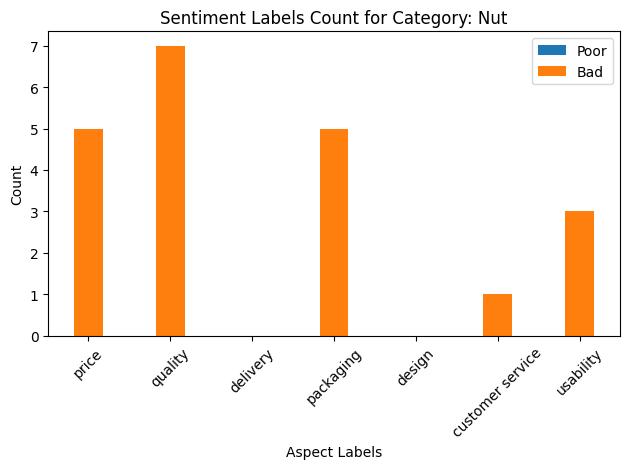

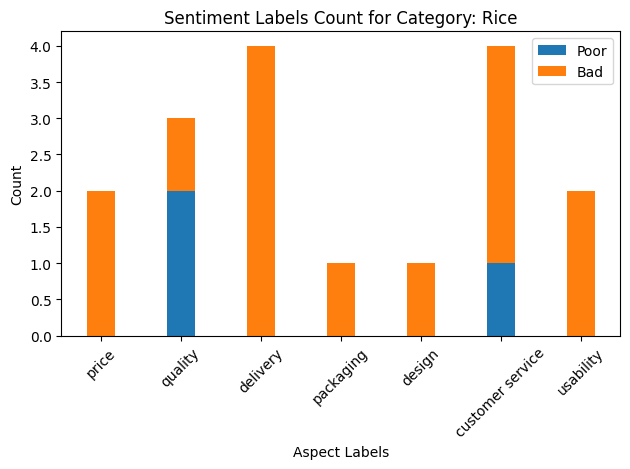

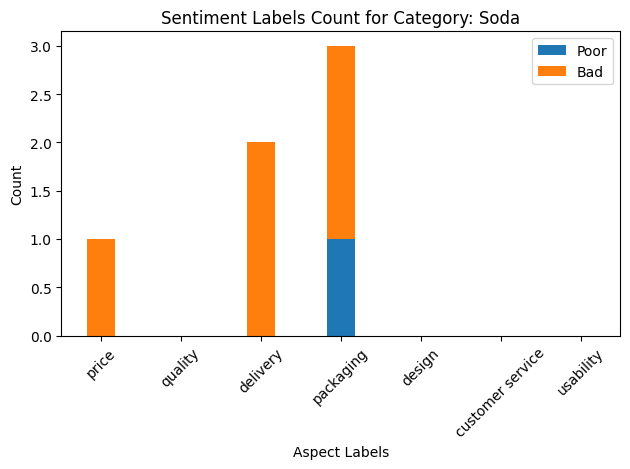

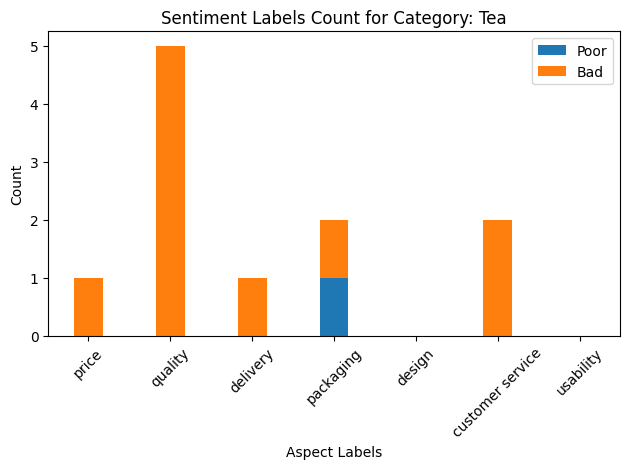

In [22]:
import matplotlib.pyplot as plt

result_df = pd.read_csv('/content/drive/MyDrive/zidan/daraz_sentiment_analysis.csv')

# Group the data by category
grouped_df = result_df.groupby('Category')

# Iterate over each category
for category, group in grouped_df:
    # Count the occurrences of each sentiment label for each aspect
    sentiment_counts = {}
    aspect_labels = ["price", "quality", "delivery", "packaging", "design", "customer service", "usability"]

    for aspect_label in aspect_labels:
        sentiment_counts[aspect_label] = {'poor': 0, 'bad': 0, 'neutral': 0, 'good': 0, 'very good': 0}

        for sentiment_label in group[aspect_label]:
            if sentiment_label == 'poor':
                sentiment_counts[aspect_label]['poor'] += 1
            elif sentiment_label == 'bad':
                sentiment_counts[aspect_label]['bad'] += 1

    # Prepare data for plotting
    labels = aspect_labels
    poor_counts = [sentiment_counts[label]['poor'] for label in labels]
    bad_counts = [sentiment_counts[label]['bad'] for label in labels]

    # Create the bar chart
    x = range(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    ax.bar(x, poor_counts, width, label='Poor')
    ax.bar(x, bad_counts, width, bottom=poor_counts, label='Bad')

    ax.set_ylabel('Count')
    ax.set_xlabel('Aspect Labels')
    ax.set_title(f'Sentiment Labels Count for Category: {category}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the chart as an image file
    plt.savefig(f'/content/drive/MyDrive/zidan/{category}_sentiment_chart.png')

    # Show the chart
    plt.show()
